The goal of the notebook to evaluate the new function that does exact matching with the cosine similarity. The donation projects are excluded from the evaluation.

In [766]:
import pandas as pd
import string
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from project_name_extractor_utils import get_project_list
from dtos.project import Project

In [767]:
ground_truth_csv_path = "/home/jovyan/work/notebook/project_name_extractor_evaluation/ground_truth_v2.csv"

# Load dataset

In [768]:
# Read Ground Truth CSV Data
data = pd.read_csv(ground_truth_csv_path, delimiter=";")

# Load the data into a DataFrame
df = pd.DataFrame(data)


Replace "NaN" with an empty string in the expected project names to avoid issues with comparison.

In [769]:
df = df.fillna("")

In [770]:
df.describe()

,source_system,project_id,project_name,subject,body,comment
count,246,246,246,246,246,246
unique,1,42,42,221,239,6
top,evdi,,,Welche Sicherheiten gibt es für Investoren?,"Sehr geehrte Damen und Herren, ich interessier...",
freq,246,28,28,4,3,218


In [771]:
df['id'] = range(1, len(df) + 1)
df.head()

,source_system,project_id,project_name,subject,body,comment,id
0,evdi,F076C5A5-740E-476B-AA35-9B25389E0A82,smartUP Self-Storage-Park II,Welche Verzinsung kann ich im Projekt 'smartUP...,Ich interessiere mich für die genauen Konditio...,Removed dashes from project name,1
1,evdi,F076C5A5-740E-476B-AA35-9B25389E0A82,smartUP Self-Storage-Park II,Wie wird mein Investment im Projekt smartUP Se...,"Können Sie mir genau erklären, welche Absicher...",Removed dashes from project name,2
2,evdi,F076C5A5-740E-476B-AA35-9B25389E0A82,smartUP Self-Storage-Park II,Wie hoch sind die Renditen für verschiedene Be...,Ich möchte mich gerne über die Rendite-Struktu...,Removed dashes from project name,3
3,evdi,F076C5A5-740E-476B-AA35-9B25389E0A82,smartUP Self-Storage-Park II,Welcher Zeitrahmen ist für die Fertigstellung ...,"Ich möchte wissen, ob es eine klare Projektpla...",Removed dashes from project name,4
4,evdi,4E10CBD1-7D59-42E7-A0E9-27A6446CFC2B,smart-UP Self-Storage-Park III,Wie werden die Mittel für das Projekt smartUP ...,"Mich würde sehr interessieren, wie genau die M...",Removed dashes from project name,5


# Load existing projects

In [772]:
projects = get_project_list()

In [773]:
projects[0:10]

[Project(id=UUID('54ee27f7-bfb3-49bd-9438-2be412c8d8a0'), name='DFI Zukunftspark Oberfranken VI'),
 Project(id=UUID('716867b4-c28c-425e-94be-59886d853d49'), name='Berliner Flair in Friedrichshain II'),
 Project(id=UUID('e2fefd3e-6841-434f-af12-6e700d7c60d3'), name='DFI Zukunftspark Nordbayern IV'),
 Project(id=UUID('d1f21f84-9eec-4d0b-a63a-bf656a28a256'), name='DFI Zukunftspark Oberfranken V'),
 Project(id=UUID('811dc8a3-c453-48a0-82dd-58df3ad52a6d'), name='Am Akkonplatz'),
 Project(id=UUID('83ff1d1c-6a7f-45bb-adff-0e42c26463a4'), name='Berliner Flair in Friedrichshain'),
 Project(id=UUID('e6ea9000-8561-4f86-8795-a60032f239f4'), name='DFI Zukunftspark Oberfranken IV'),
 Project(id=UUID('4973e74a-e88e-4e1b-b534-36615368d4a6'), name='Tonhallen-Passage II'),
 Project(id=UUID('35f259f1-4160-4768-9c7a-9ecbda485ba0'), name='DFI Zukunftspark Nordbayern III'),
 Project(id=UUID('41e842bb-6963-4ce9-bc24-1c0a58648d7a'), name='DFI Zukunftspark Oberfranken III')]

In [774]:
print(df['project_name'].value_counts())

project_name
                                             28
Büro-Hochhaus am Scheidemannplatz II         18
DFI Zukunftspark Dreiländereck II            12
smartUP Self-Storage-Park II                 10
smart-UP Self-Storage-Park III               10
DFI Zukunftspark Dreiländereck                8
Friedrichstraße 191 III                       8
DFI Zukunftspark Oberfranken VI               6
DFI Zukunftspark Nordbayern IV                6
Berliner Flair in Friedrichshain II           6
Stadthaus Mozart III                          6
DFI Zukunftspark Oberfranken IV               6
Berliner Flair in Friedrichshain              6
Am Akkonplatz                                 6
DFI Zukunftspark Oberfranken V                6
DFI Zukunftspark Nordbayern III               6
Wohnquartier Pasing II                        6
DFI Zukunftspark Mittelfranken                6
DFI Zukunftspark Oberfranken III              6
Stadthaus Mozart IV                           6
Tonhallen-Passage II       

In [775]:
from typing import NamedTuple
from uuid import UUID

class ProjectMatch(NamedTuple):
    name: str
    id: UUID
    similarity: float

In [776]:
from typing import List


def get_project_by_project_match(project_match: ProjectMatch, projects: List[Project]) -> Project:
    for project in projects:
        if project_match.id == project.id:
            return project

    raise None

# The first attempt with string matching and cosine similarity

## Analize the data

In [777]:
def preprocess_text(text: str) -> str:
    text = text.replace("\n", " ").replace("\r", " ").replace("\t", " ")
    text = text.lower().strip()
    punctuations = string.punctuation
    for char in punctuations:
        text = text.replace(char, "")

    return text

In [778]:
def create_project(project: Project) -> Project:
    project_name = preprocess_text(project.name)
    project = Project(project.id, project_name)
    return project

preprocessed_projects = [ create_project(project) for project in projects ]
preprocessed_projects[40:]

[Project(id=UUID('afdd98b3-b93c-4803-8d60-ff1733217768'), name='stadthaus mozart ii'),
 Project(id=UUID('c827f162-6205-4688-84eb-6e1e2934595e'), name='prachtaltbau sendlinger tor ii'),
 Project(id=UUID('2e239357-4967-40e6-807e-b9eb87fab5ad'), name='prachtaltbau sendlinger tor'),
 Project(id=UUID('550bd3a9-ce29-4d6c-9993-2fc56ad7ec5a'), name='berggrün anwesen garmisch'),
 Project(id=UUID('3a9550bd-e2c9-64dc-9399-d7e2f6a5c5ca'), name='berggrün anwesen garmisch iv'),
 Project(id=UUID('38be4dc2-f4f3-46b4-b74a-a2e70e2d4e8c'), name='stadtleben am bodensee i'),
 Project(id=UUID('8be34dc2-3f4f-6b44-4b7a-e2e70d4e82ac'), name='stadtleben am bodensee ii'),
 Project(id=UUID('a1375e89-14cd-45a3-a1e4-8df17a8d82a1'), name='rheinknieresidenz bonn vi'),
 Project(id=UUID('6bf14376-dd72-49b7-a76f-4b1e0b65d38a'), name='metropolkomplex dortmund ii'),
 Project(id=UUID('9d9ee4a0-8bbf-4870-9382-c63b4d90ac12'), name='weidengrund hauptstadt iii'),
 Project(id=UUID('02c7b6db-9a66-4293-9c26-5b5bff0dd9ef'), name='

In [779]:
sorted_projects_with_preprocessed_names = sorted(preprocessed_projects, key=lambda p: len(p.name), reverse=True)

In [780]:
sorted_projects_with_preprocessed_names[45:55]

[Project(id=UUID('771aae7a-362c-4f0f-b969-32f29f19af08'), name='eco living lichtenrade'),
 Project(id=UUID('b8b56e01-b594-4c14-99a8-65fa36203fcc'), name='bergkulisse oberbayern'),
 Project(id=UUID('7f5fee56-a4ff-4d66-ac5f-fdb6ef7ce1b1'), name='schlossviertel weimar'),
 Project(id=UUID('180770c4-5fe2-481b-b2cf-6bef10a9b400'), name='stadthaus mozart iii'),
 Project(id=UUID('755db000-4f7c-4ad6-a4a0-c7ea67b26c2e'), name='an der kleinen weser'),
 Project(id=UUID('4973e74a-e88e-4e1b-b534-36615368d4a6'), name='tonhallenpassage ii'),
 Project(id=UUID('4d8f9f51-556b-4ad5-8223-7f7b96f16ebe'), name='stadthaus mozart iv'),
 Project(id=UUID('afdd98b3-b93c-4803-8d60-ff1733217768'), name='stadthaus mozart ii'),
 Project(id=UUID('2cd2f6c0-8c0a-4f7b-be21-7aadfa8f0b0e'), name='straßburgblick kehl'),
 Project(id=UUID('710d7579-2500-480f-8169-e2350c2a6abf'), name='solarpark eyendorf')]

## The Project Identifier Service

In [781]:
from typing import List
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

from dtos.identified_project import IdentifiedProject


class ProjectIdentifierService:
    def __init__(self, projects: List[Project]):
        self._projects = projects

        preprocessed_projects = [ create_project(project) for project in projects ]
        self._sorted_projects_with_preprocessed_names = sorted(preprocessed_projects, key=lambda p: len(p.name), reverse=True)

        self._model_name = "sentence-transformers/distiluse-base-multilingual-cased-v1"
        self._tokenizer = AutoTokenizer.from_pretrained(self._model_name)
        self._model = AutoModel.from_pretrained(self._model_name)

        # Get embeddings for each project name
        self._project_embeddings = [self._get_embeddings(project.name) for project in self._projects]

    def extract_project_name(self, query: str) -> ProjectMatch:
        matched_projects = self.get_matched_projects(query)

        if matched_projects:
            project = matched_projects[0]
            confidence = 1  # Exact match, so confidence is 100%

            return ProjectMatch(project.name, project.id, confidence)

        # Step 2: If no exact match, fall back to similarity matching
        project_match = self.extract_project_using_embeddings(query)

        confidence = (project_match.similarity + 1) / 2

        return ProjectMatch(project_match.name, project_match.id, confidence)

    def get_matched_projects(self, query) -> List[Project]:
        query = preprocess_text(query)
        matched_projects = [project for project in self._sorted_projects_with_preprocessed_names if project.name in query]

        return matched_projects

    def extract_project_using_embeddings(self, input_text: str) -> ProjectMatch | None:
        # Get embeddings for the input text
        input_text = input_text.replace("\n", " ").replace("\r", " ").replace("\t", " ").strip()

        input_embedding = self._get_embeddings(input_text)

        # Compute cosine similarities between input text and each project name
        similarities: List[float] = [cosine_similarity(input_embedding.unsqueeze(0), proj_emb.unsqueeze(0)).item() for proj_emb in self._project_embeddings]

        max_similarity_value: float = max(similarities)

        # Find the most similar project name
        best_match_index = similarities.index(max_similarity_value)
        best_project = self._projects[best_match_index]

        return ProjectMatch(best_project.name, best_project.id, max_similarity_value)

    # Tokenization function
    def _get_embeddings(self, text: str):
        inputs = self._tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = self._model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze()

In [782]:
project_identifier_service = ProjectIdentifierService(projects)

In [783]:
from pandas import Series


def process_row(row: Series) -> ProjectMatch:
    row_as_dict = row.to_dict()
    query = row_as_dict["subject"] + " " + row_as_dict["body"]
    extracted_project = project_identifier_service.extract_project_name(query)

    return extracted_project

### Test the approach for one row

In [784]:
item = df.iloc[123]
item

source_system                                                 evdi
project_id                    180770C4-5FE2-481B-B2CF-6BEF10A9B400
project_name                                  Stadthaus Mozart III
subject                 Renditeaussichten für Stadthaus Mozart III
body             Sehr geehrtes Team, ich interessiere mich für ...
comment                                                           
id                                                             124
Name: 123, dtype: object

In [785]:
project_match = process_row(item)
project_name = get_project_by_project_match(project_match, projects)
project_name

Project(id=UUID('180770c4-5fe2-481b-b2cf-6bef10a9b400'), name='Stadthaus Mozart III')

In [786]:
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    project_match = process_row(row)
    extracted_project_name = get_project_by_project_match(project_match, projects).name

    df.at[idx, "extracted_project_name"] = extracted_project_name
    df.at[idx, "extracted_project_similarity"] = project_match.similarity

100%|██████████| 246/246 [00:50<00:00,  4.87it/s]


In [787]:
mask = (df["project_name"] != df["extracted_project_name"])
different_values_df = df[mask]
len(different_values_df)

31

In [788]:
different_values_df.sort_values(by="extracted_project_similarity", ascending=False)

,source_system,project_id,project_name,subject,body,comment,id,extracted_project_name,extracted_project_similarity
243,evdi,,,Gibt es Umwelt- und Nachhaltigkeitsaspekte bei...,Da nachhaltige Projekte mir sehr am Herzen lie...,,244,Spendenprojekt - Green Forest Fund,0.655664
220,evdi,,,Wie wird die Finanzierung des Projekts gesichert?,Ich würde gerne mehr über die Sicherheiten des...,,221,Spendenprojekt - Green Forest Fund,0.637188
221,evdi,,,Ab wann erhalte ich die erste Rendite?,Wann beginnt die Auszahlung der Zinsen für die...,,222,Spendenprojekt - Green Forest Fund,0.634198
218,evdi,,,Welche Laufzeit hat das Investmentprojekt?,"Könnten Sie mir bitte mitteilen, wie lange das...",,219,Spendenprojekt - Green Forest Fund,0.628932
141,evdi,04DF54CA-2B08-4545-ADD1-EA4D6301E993,Büro-Hochhaus am Scheidemannplatz II,Fragen zur Finanzierung des Buero-Hochhauses a...,"Sehr geehrte Damen und Herren, ich interessier...",Replaced ü with ue,142,Spendenprojekt - Green Forest Fund,0.627411
244,evdi,,,Wie wird die geplante Verzinsung für mein Inve...,"Ich würde gerne genau erfahren, wie die Verzin...",,245,Spendenprojekt - Green Forest Fund,0.621398
224,evdi,,,Wie lange dauert die Finanzierung dieses Proje...,Wie lange ist die geplante Dauer der Finanzier...,,225,Spendenprojekt - Green Forest Fund,0.619019
222,evdi,,,Wie lange dauert die Projektlaufzeit?,Wie lange ist die geplante Laufzeit dieses Pro...,,223,Spendenprojekt - Green Forest Fund,0.618675
236,evdi,,,Welche Laufzeit ist für dieses Projekt vorgese...,Wie lange dauert die Laufzeit dieses Projekts ...,,237,Spendenprojekt - Green Forest Fund,0.618027
144,evdi,04DF54CA-2B08-4545-ADD1-EA4D6301E993,Büro-Hochhaus am Scheidemannplatz II,Sicherheiten und Risikoabsicherung beim Immobi...,"Sehr geehrte Damen und Herren, als potenzielle...",Replaced ü with ue,145,Atelier-Wohnungen an der Burg II,0.616382


Based on the results, the project names with replaced umlauts are not matched.

In [789]:
max(different_values_df["extracted_project_similarity"])

0.6556643545627594

In [790]:
mask = df["project_id"] == "CC215696-CDDF-43B2-BB79-BD204EFD64F3"
green_forest_fund_df = df[mask]
green_forest_fund_df

,source_system,project_id,project_name,subject,body,comment,id,extracted_project_name,extracted_project_similarity
188,evdi,CC215696-CDDF-43B2-BB79-BD204EFD64F3,Spendenprojekt - Green Forest Fund,Wie wird die Rendite beim Spendenprojekt - Gre...,Wie wird die Rendite in diesem Projekt berechn...,,189,Spendenprojekt - Green Forest Fund,1.000000
189,evdi,CC215696-CDDF-43B2-BB79-BD204EFD64F3,Spendenprojekt - Green Forest Fund,Wie hoch ist das Risiko für das Spendenprojekt...,Wie wird das Risiko dieses Projekts bewertet u...,,190,Spendenprojekt - Green Forest Fund,1.000000
190,evdi,CC215696-CDDF-43B2-BB79-BD204EFD64F3,Spendenprojekt - Green Forest Fund,Sicherheit und Renditepotenzial?,Welche Sicherheitsmaßnahmen gibt es beim Green...,,191,Spendenprojekt - Green Forest Fund,0.701831


### Get the rows are predicted with cosine similarity

In [791]:
mask = (df["extracted_project_similarity"] < 1)
predicted_by_similarity_logic = df[mask]
predicted_by_similarity_logic.sort_values(by='extracted_project_similarity', ascending=False)[10:20]

,source_system,project_id,project_name,subject,body,comment,id,extracted_project_name,extracted_project_similarity
210,evdi,118BBDEC-3A71-4E5F-B725-BDC85E4A31EB,Stadthaus 'Mozart',Wie lange dauert die Finanzierung des Stadthau...,Können Sie mir die geplante Dauer des Projekts...,,211,Stadthaus 'Mozart',0.694309
84,evdi,A0D1803B-9018-4774-82A4-AAB4668E19C6,Friedrichstraße 191 III,Wie sicher ist mein Kapital im Projekt Friedri...,"Welche Sicherheitsmaßnahmen gibt es, um mein K...",Replaced ß with ss in the project name,85,Friedrichstraße 191 III,0.686954
3,evdi,F076C5A5-740E-476B-AA35-9B25389E0A82,smartUP Self-Storage-Park II,Welcher Zeitrahmen ist für die Fertigstellung ...,"Ich möchte wissen, ob es eine klare Projektpla...",Removed dashes from project name,4,smartUP Self-Storage-Park II,0.686480
111,evdi,4E10CBD1-7D59-42E7-A0E9-27A6446CFC2B,smart-UP Self-Storage-Park III,Rentabilitätsaussichten und Zinssätze für Inve...,"Sehr geehrtes Team, ich interessiere mich für ...",,112,smart-UP Self-Storage-Park III,0.679907
145,evdi,04DF54CA-2B08-4545-ADD1-EA4D6301E993,Büro-Hochhaus am Scheidemannplatz II,Detailfragen zum Buero-Hochhaus am Scheidemann...,"Guten Tag, ich habe einige spezifische Fragen ...",Replaced ü with ue,146,Büro-Hochhaus am Scheidemannplatz II,0.676533
83,evdi,A0D1803B-9018-4774-82A4-AAB4668E19C6,Friedrichstraße 191 III,Wann beginnt die Verzinsung im Projekt Friedri...,"Ich möchte wissen, ab wann die Verzinsung für ...",Replaced ß with ss in the project name,84,Friedrichstraße 191 III,0.676426
85,evdi,A0D1803B-9018-4774-82A4-AAB4668E19C6,Friedrichstraße 191 III,Friedrichstrasse 191 III – Welche Rendite kann...,Ich interessiere mich für die voraussichtliche...,Replaced ß with ss in the project name,86,Friedrichstraße 191 III,0.674499
74,evdi,BAFBFF1D-8953-48DD-922F-95489B0334FA,DFI Zukunftspark Dreiländereck II,Wie sicher ist mein Investment in diesem Projekt?,"Welche Sicherheitsvorkehrungen gibt es, um mei...",Umlaut is replaced with ae,75,DFI Zukunftspark Dreiländereck II,0.672921
215,evdi,AFDD98B3-B93C-4803-8D60-FF1733217768,Stadthaus 'Mozart' II,Wann beginnt die Auszahlung der Zinsen für die...,Wann erhalte ich die ersten Zinszahlungen für ...,,216,Stadthaus 'Mozart' II,0.662006
112,evdi,4E10CBD1-7D59-42E7-A0E9-27A6446CFC2B,smart-UP Self-Storage-Park III,Sicherheitskonzept und Risikoanalyse der Inves...,"Guten Tag, als potenzieller Investor möchte ic...",,113,smart-UP Self-Storage-Park III,0.660532


# Examine metrics and confusion matrix

In [834]:
similarity_threshold = 0.5

predicted_df = pd.DataFrame(df)
predicted_df["extracted_project_name"] = predicted_df.apply(
    lambda row: row["extracted_project_name"] if row["extracted_project_name"] == row["project_name"] and row["extracted_project_similarity"] >= similarity_threshold else "",
    axis=1
)


In [835]:
predicted_df.sort_values(by='extracted_project_similarity', ascending=True)

,source_system,project_id,project_name,subject,body,comment,id,extracted_project_name,extracted_project_similarity
241,evdi,,,Wie werden die Zinsen berechnet?,Wie erfolgt die Berechnung der Zinsen und wie ...,,242,,0.536101
226,evdi,,,Wann beginnen die Zinszahlungen?,Ab wann kann ich mit den Zinszahlungen rechnen...,,227,,0.541897
232,evdi,,,Welche Sicherheiten werden bei dieser Investit...,"Welche Sicherheiten gibt es, um das Risiko für...",,233,,0.554982
228,evdi,,,Wann beginnen die Zinsauszahlungen?,"Könnten Sie bitte erläutern, ab wann die Ausza...",,229,,0.557401
237,evdi,,,Wann erfolgt die Zinsauszahlung?,Wann werden die Zinszahlungen für mein Investm...,,238,,0.558999
...,...,...,...,...,...,...,...,...,...
194,evdi,2B23BAF6-503B-4A55-A4C2-52F075B681A9,DFI Zukunftspark Oberfranken II,Wie hoch ist die Rendite beim DFI Zukunftspark...,Welche Rendite kann ich bei dieser Investition...,,195,DFI Zukunftspark Oberfranken II,1.000000
197,evdi,280FBEAB-D3BC-47CD-AD6F-66ED4A55DC76,Office am Europaring III,Wie ist das Risiko beim Projekt Office am Euro...,Wie schätzen Sie das Risiko für dieses Projekt...,,198,Office am Europaring III,1.000000
196,evdi,280FBEAB-D3BC-47CD-AD6F-66ED4A55DC76,Office am Europaring III,Welche Zinserwartungen gibt es beim Projekt Of...,Wie hoch wird die Verzinsung für die Investore...,,197,Office am Europaring III,1.000000
193,evdi,5F74EEEB-0F8A-4A85-84B7-590EA468A2E6,Bürokomplex Alemannenhof III,Vorteile und Sicherheiten für Investoren?,Welche Vorteile und Sicherheiten werden den In...,,194,Bürokomplex Alemannenhof III,1.000000


In [836]:
# Ground truth and predictions
y_true = predicted_df['project_name']
y_pred = predicted_df['extracted_project_name']

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average="macro")
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

# Print results
print(f"Accuracy_macro: {accuracy}")
print(f"Precision_macro: {precision_macro}")
print(f"Recall_macro: {recall_macro}")
print(f"F1 Score_macro: {f1_macro}")

Accuracy_macro: 0.9878048780487805
Precision_macro: 0.9976958525345623
Recall_macro: 0.996031746031746
F1 Score_macro: 0.9966248440824712


In [837]:
predicted_incorrectly_df = predicted_df[predicted_df["project_name"] != predicted_df["extracted_project_name"]]
len(predicted_incorrectly_df)

3

In [838]:
predicted_incorrectly_df

,source_system,project_id,project_name,subject,body,comment,id,extracted_project_name,extracted_project_similarity
141,evdi,04DF54CA-2B08-4545-ADD1-EA4D6301E993,Büro-Hochhaus am Scheidemannplatz II,Fragen zur Finanzierung des Buero-Hochhauses a...,"Sehr geehrte Damen und Herren, ich interessier...",Replaced ü with ue,142,,0.627411
143,evdi,04DF54CA-2B08-4545-ADD1-EA4D6301E993,Büro-Hochhaus am Scheidemannplatz II,Investitionsmöglichkeiten und Renditeerwartungen,"Sehr geehrtes Team, ich interessiere mich für ...",Replaced ü with ue,144,,0.614688
144,evdi,04DF54CA-2B08-4545-ADD1-EA4D6301E993,Büro-Hochhaus am Scheidemannplatz II,Sicherheiten und Risikoabsicherung beim Immobi...,"Sehr geehrte Damen und Herren, als potenzielle...",Replaced ü with ue,145,,0.616382


Сreate a table with False Positive (FP), False Negative (FN), True Positive (TP), and True Negative (TN) for every incorrectly predicted project name

In [839]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Ground truth and predictions
y_true = predicted_df['project_name']
y_pred = predicted_df['extracted_project_name']

# Compute confusion matrix
labels = y_true.unique()
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Create a DataFrame to store the results
results = pd.DataFrame(columns=['project_name', 'FP', 'FN', 'TP', 'TN'])

# Populate the DataFrame
rows = []
for i, label in enumerate(labels):
    FP = cm[:, i].sum() - cm[i, i]
    FN = cm[i, :].sum() - cm[i, i]
    TP = cm[i, i]
    TN = cm.sum() - (FP + FN + TP)
    rows.append({'project_name': label, 'FP': FP, 'FN': FN, 'TP': TP, 'TN': TN})

results = pd.concat([results, pd.DataFrame(rows)], ignore_index=True)

# Filter the results to show only incorrectly predicted project names
incorrect_results = results[(results['FP'] > 0) | (results['FN'] > 0)]

# Display the table
print(incorrect_results)

                            project_name FP FN  TP   TN
20  Büro-Hochhaus am Scheidemannplatz II  0  3  15  228
41                                        3  0  28  215


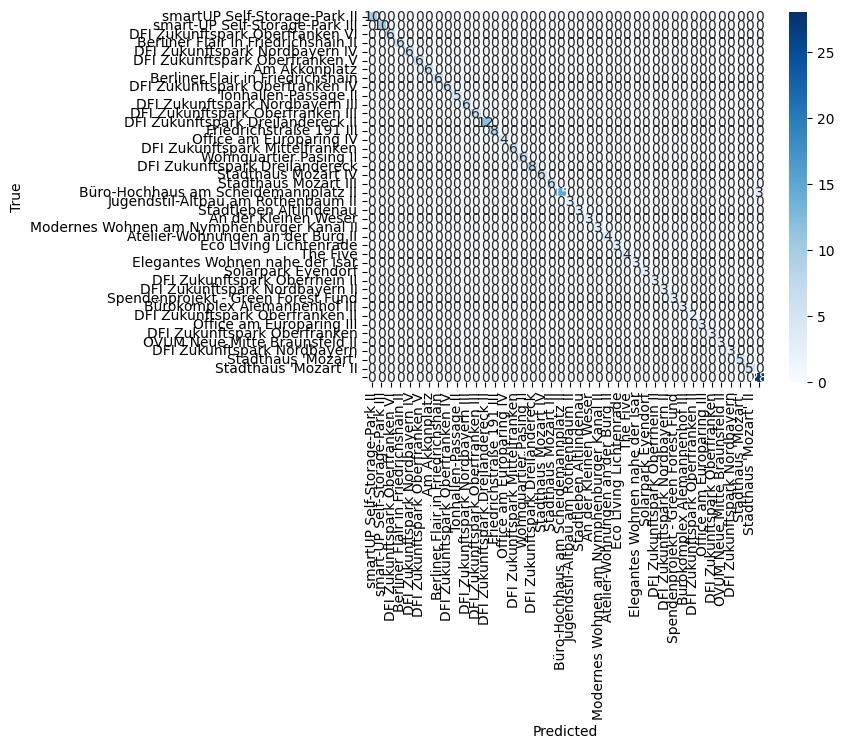

In [840]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=df['project_name'].unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['project_name'].unique(), yticklabels=df['project_name'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# The second attempt with adding fuzzy matching - HAS NOT BEEN COMPLETED

### Analize the cases that include the umlauts

In [841]:
item_142 = different_values_df[(different_values_df["id"] == 142)]

item_142_project_name = item_142["project_name"].values[0]
item_142_subject = item_142["subject"].values[0]
item_142_body = item_142["body"].values[0]
item_142_extracted_project_name = item_142["extracted_project_name"].values[0]

print(item_142_project_name)
print(item_142_subject)
print(item_142_body)
print(item_142_extracted_project_name)

Büro-Hochhaus am Scheidemannplatz II
Fragen zur Finanzierung des Buero-Hochhauses am Scheidemannplatz II
Sehr geehrte Damen und Herren, ich interessiere mich für eine Investition in Ihr aktuelles Projekt. Könnten Sie mir bitte detaillierte Informationen zur geplanten Finanzierungsstruktur geben? Mich würde besonders interessieren, wie hoch der Eigenkapitalanteil ist und ob es bereits Zusagen von anderen Investoren gibt. Außerdem möchte ich gerne wissen, wie Sie das Verhältnis von Risiko zu Rendite in diesem Projekt einschätzen. Gibt es spezielle Maßnahmen, um das Investitionsrisiko zu minimieren?
Spendenprojekt - Green Forest Fund


In [842]:
from fuzzywuzzy import fuzz

fuzzy_similarity = fuzz.ratio(item_142_project_name, "Buero-Hochhaus am Scheidemannplatz II")
fuzzy_similarity

96

In [843]:
query = item_142_subject + " " + item_142_body
query

'Fragen zur Finanzierung des Buero-Hochhauses am Scheidemannplatz II Sehr geehrte Damen und Herren, ich interessiere mich für eine Investition in Ihr aktuelles Projekt. Könnten Sie mir bitte detaillierte Informationen zur geplanten Finanzierungsstruktur geben? Mich würde besonders interessieren, wie hoch der Eigenkapitalanteil ist und ob es bereits Zusagen von anderen Investoren gibt. Außerdem möchte ich gerne wissen, wie Sie das Verhältnis von Risiko zu Rendite in diesem Projekt einschätzen. Gibt es spezielle Maßnahmen, um das Investitionsrisiko zu minimieren?'

In [844]:
from fuzzywuzzy import process


fuzzy_project_names = [project.name for project in projects]
fuzzy_match, confidence = process.extractOne(query, fuzzy_project_names)

print(f"Fuzzy Match: {fuzzy_match}")
print(f"Confidence: {confidence}")

best = process.extractBests(query, fuzzy_project_names)
print(best)

Fuzzy Match: Berliner Flair in Friedrichshain II
Confidence: 57
[('Berliner Flair in Friedrichshain II', 57), ('Am Akkonplatz', 57), ('Berliner Flair in Friedrichshain', 57), ('Tonhallen-Passage II', 57), ('DFI Zukunftspark Dreiländereck II', 57)]


In [845]:
project_identifier_service = ProjectIdentifierService(projects)

In [846]:
project_match = project_identifier_service.extract_project_name(query)
print(project_match)

ProjectMatch(name='Spendenprojekt - Green Forest Fund', id=UUID('cc215696-cddf-43b2-bb79-bd204efd64f3'), similarity=0.627410501241684)


In [847]:
query = "Fragen zur Finanzierung des Büro-Hochhauses am Scheidemannplatz II" + " " + item_142_body

In [848]:
project_match = project_identifier_service.extract_project_name(query)
print(project_match)

ProjectMatch(name='Büro-Hochhaus am Scheidemannplatz II', id=UUID('04df54ca-2b08-4545-add1-ea4d6301e993'), similarity=0.643467903137207)
